# Fully retrain the VGG16 model on Fruit360 Dataset

# 1. import dependency

In [6]:
import os
from os import listdir, makedirs
from os.path import join, exists, expanduser

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


# 2. Setep directory

In [7]:
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [8]:
print("Available Pretrained Models:\n")
listdir(models_dir)

Available Pretrained Models:



['imagenet_class_index.json',
 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5',
 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'inception_v3_weights_tf_dim_ordering_tf_kernels.h5',
 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'vgg16_weights_tf_dim_ordering_tf_kernels.h5',
 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'xception_weights_tf_dim_ordering_tf_kernels.h5',
 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5']

In [9]:
# dimensions of our images.
img_width, img_height = 224, 224

In [10]:
train_data_dir = './fruits-360/Training/'
test_data_dir = './fruits-360/Test/'
batch_size = 16

# 3. Reading the Data

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./ 255)


In [12]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


# 4. Building and Compiling the Model

Building the models

In [14]:
save_path = "vgg16_full_fit.h5"
trained = False

Load last trained model or create model

In [15]:
if os.path.exists(save_path):
    print("Load trained model from",save_path)
    vgg16_full = tf.keras.models.load_model(save_path)
    trained = True
else:
    print("Creating model..")
    #import vgg16 with pre-trained weights. do not include fully #connected layers
    vgg16_base = applications.VGG16(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = vgg16_base.output
    x = GlobalAveragePooling2D()(x)
    # add a fully-connected layer
    x = Dense(512, activation='relu')(x)
    # and a fully connected output/classification layer
    predictions = Dense(131, activation='softmax')(x)
    vgg16_full = Model(inputs=vgg16_base.input, outputs=predictions)
    vgg16_full.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

Load trained model from vgg16_full_fit.h5


# 5. Training and Validating the Model

## Train the model

In [18]:
if !trained:
    with tf.device("/device:GPU:0"):
        history_pretrained =vgg16_full.fit_generator(
        train_generator,
        epochs=5, shuffle = True, verbose = 1, validation_data = validation_generator)

Epoch 1/5
3387/3387 [==============================] - 1226s 362ms/step - loss: 1.5702 - accuracy: 0.6384 - val_loss: 0.2175 - val_accuracy: 0.9245
Epoch 2/5
3387/3387 [==============================] - 1186s 350ms/step - loss: 0.0542 - accuracy: 0.9842 - val_loss: 0.0259 - val_accuracy: 0.9842
Epoch 3/5
3387/3387 [==============================] - 1130s 334ms/step - loss: 0.0220 - accuracy: 0.9941 - val_loss: 0.0311 - val_accuracy: 0.9783
Epoch 4/5
3387/3387 [==============================] - 2162s 638ms/step - loss: 0.0170 - accuracy: 0.9958 - val_loss: 0.0460 - val_accuracy: 0.9807
Epoch 5/5
3387/3387 [==============================] - 1189s 351ms/step - loss: 0.0077 - accuracy: 0.9984 - val_loss: 0.4379 - val_accuracy: 0.9876


In [19]:
vgg16_full.save(save_path)

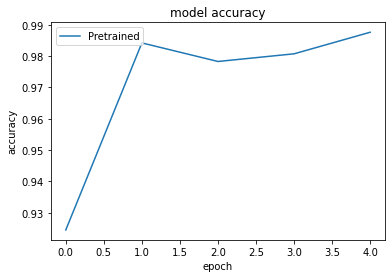

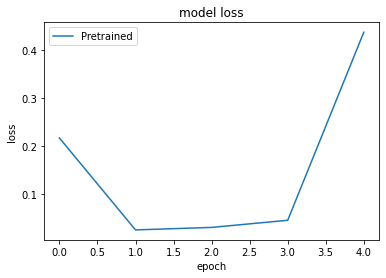

In [23]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Pretrained'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_pretrained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Pretrained'], loc='upper left')
plt.show()

# Evalute model on test data set

In [ ]:
history_pretrained_eval = vgg16_full.evaluate_generator(generator=test_generator,verbose = 1)

In [29]:
for name,value in zip(vgg16_full.metrics_names, history_pretrained_eval):
    print(f"{name}: {value}")

loss: 0.19145259261131287
accuracy: 0.9802098274230957


In [30]:
vgg16_full.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   